In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!git clone -q https://github.com/JingyunLiang/SwinIR.git /content/SwinIR

import sys
sys.path.append('/content/SwinIR')

print("Drive mounted and SwinIR repo added to path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path '/content/SwinIR' already exists and is not an empty directory.
Drive mounted and SwinIR repo added to path.


In [ ]:

import os
from pathlib import Path

ZIP_FL_PATH = "/content/drive/MyDrive/DeepLearning/fl_imgs.zip"
ZIP_NF_PATH = "/content/drive/MyDrive/DeepLearning/nf_imgs.zip"

FL_ROOT = Path("/content/fl_imgs")
NF_ROOT = Path("/content/nf_imgs")
FL_ROOT.mkdir(parents=True, exist_ok=True)
NF_ROOT.mkdir(parents=True, exist_ok=True)

SR_512_DIR = Path("/content/drive/MyDrive/DeepLearning/generated_fl_nf_sr")
SR_512_DIR.mkdir(parents=True, exist_ok=True)

!unzip -q "{ZIP_FL_PATH}" -d "{FL_ROOT}"
!unzip -q "{ZIP_NF_PATH}" -d "{NF_ROOT}"

FL_GEN_DIR   = FL_ROOT / "1" / "generated"
FL_ORIG_DIR  = FL_ROOT / "1" / "original"
NF_GEN_DIR   = NF_ROOT / "0" / "generated"
NF_ORIG_DIR  = NF_ROOT / "0" / "original"

print("FL generated dir:", FL_GEN_DIR)
print("NF generated dir:", NF_GEN_DIR)
print("Super-resolved images will be saved to:", SR_512_DIR)

replace /content/fl_imgs/1/generated/hmi.sharp_cea_720s.1256.20111231_200000_TAI.magnetogram.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
FL generated dir: /content/fl_imgs/1/generated
NF generated dir: /content/nf_imgs/0/generated
Super-resolved images will be saved to: /content/drive/MyDrive/DeepLearning/generated_fl_nf_sr


In [ ]:
# Build dataset & dataloader
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path

img_paths = []
labels = []
label_to_paths = {"FL": [], "NF": []}

# FL images
fl_paths = sorted(glob.glob(str(FL_GEN_DIR / "*.*")))
fl_selected = fl_paths[:100]
print(f"FL generated: found {len(fl_paths)} images, using {len(fl_selected)}")

img_paths.extend(fl_selected)
labels.extend(["FL"] * len(fl_selected))
label_to_paths["FL"] = fl_selected

# NF images
nf_paths = sorted(glob.glob(str(NF_GEN_DIR / "*.*")))
nf_selected = nf_paths[:100]
print(f"NF generated: found {len(nf_paths)} images, using {len(nf_selected)}")

img_paths.extend(nf_selected)
labels.extend(["NF"] * len(nf_selected))
label_to_paths["NF"] = nf_selected

print("Total images used:", len(img_paths))

class Generated256Dataset(Dataset):
    def __init__(self, img_paths, labels):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        label_str = self.labels[idx]
        img = Image.open(path).convert("RGB")
        tensor = self.transform(img)
        return tensor, path, label_str

if len(img_paths) == 0:
    raise RuntimeError(
        "No generated images found. Check that FL_GEN_DIR and NF_GEN_DIR exist "
        "and that the zips unzipped correctly."
    )

gen_dataset = Generated256Dataset(img_paths, labels)
gen_loader = DataLoader(gen_dataset, batch_size=8, shuffle=False, num_workers=2)

sample_tensor, sample_path, sample_label = gen_dataset[0]
print("Sample tensor shape:", sample_tensor.shape,
      "from", sample_path, "label:", sample_label)

FL generated: found 930 images, using 100
NF generated: found 54622 images, using 100
Total images used: 200
Sample tensor shape: torch.Size([1, 256, 256]) from /content/fl_imgs/1/generated/hmi.sharp_cea_720s.1028.20111102_220000_TAI.magnetogram.png label: FL


In [ ]:
#Load trained SwinIR x2 model
import torch
from models.network_swinir import SwinIR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# same architecture as used during training
model = SwinIR(
    upscale=2,
    in_chans=1,
    img_size=64,
    window_size=8,
    img_range=1.0,
    depths=[6, 6, 6, 6],
    embed_dim=60,
    num_heads=[6, 6, 6, 6],
    mlp_ratio=2.0,
    upsampler='pixelshuffle',
    resi_connection='1conv'
).to(device)

CKPT_PATH = "/content/drive/MyDrive/sharp_sr_checkpoints_3p5k/swinir_solar_x2_medium_3p5k_epoch20.pth"

state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

print("Loaded SwinIR checkpoint from:", CKPT_PATH)

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Using device: cuda
Loaded SwinIR checkpoint from: /content/drive/MyDrive/sharp_sr_checkpoints_3p5k/swinir_solar_x2_medium_3p5k_epoch20.pth


In [ ]:
# Run super-resolution
import numpy as np
from PIL import Image
import os

@torch.no_grad()
def run_sr_on_generated():
    count = 0
    for lr_batch, path_batch, label_batch in gen_loader:
        lr_batch = lr_batch.to(device)
        sr_batch = model(lr_batch)
        sr_batch = torch.clamp(sr_batch, 0.0, 1.0)

        for sr_img, in_path, lbl in zip(sr_batch, path_batch, label_batch):
            sr_np = sr_img.squeeze(0).cpu().numpy()
            sr_np = (sr_np * 255.0).round().astype(np.uint8)

            in_name = os.path.basename(in_path)
            stem, _ = os.path.splitext(in_name)

            out_subdir = SR_512_DIR / lbl
            out_subdir.mkdir(parents=True, exist_ok=True)

            out_path = out_subdir / f"{stem}_sr.png"
            Image.fromarray(sr_np).save(out_path)
            count += 1

    print(f"Done. Saved {count} super-resolved images to: {SR_512_DIR}")

run_sr_on_generated()

Done. Saved 200 super-resolved images to: /content/drive/MyDrive/DeepLearning/generated_fl_nf_sr


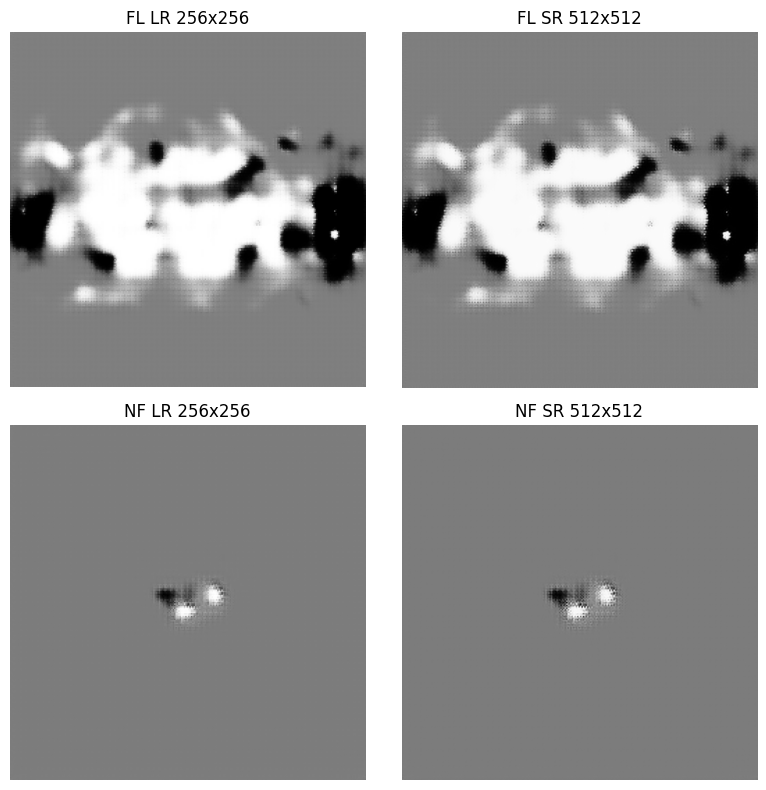

In [ ]:

import matplotlib.pyplot as plt

def show_fl_nf_examples(label_to_paths):
    labels = ["FL", "NF"]
    n_labels = len(labels)
    fig, axes = plt.subplots(n_labels, 2, figsize=(8, 4 * n_labels))

    if n_labels == 1:
        axes = [axes]

    for row_idx, lbl in enumerate(labels):
        paths = label_to_paths.get(lbl, [])
        if not paths:
            print(f"No paths stored for label {lbl}, skipping.")
            continue

        lr_path = paths[0]
        stem = os.path.splitext(os.path.basename(lr_path))[0]
        sr_path = SR_512_DIR / lbl / f"{stem}_sr.png"

        lr_img = Image.open(lr_path).convert("L")
        sr_img = Image.open(sr_path).convert("L")

        ax_lr, ax_sr = axes[row_idx]

        ax_lr.imshow(lr_img, cmap="gray", vmin=0, vmax=255)
        ax_lr.set_title(f"{lbl} LR 256x256")
        ax_lr.axis("off")

        ax_sr.imshow(sr_img, cmap="gray", vmin=0, vmax=255)
        ax_sr.set_title(f"{lbl} SR 512x512")
        ax_sr.axis("off")

    plt.tight_layout()
    plt.show()

show_fl_nf_examples(label_to_paths)